In [1]:
import sys
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/Data loader')
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/LyA/commands')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from readTrc_4CH import Trc
from tqdm import tqdm
import scipy.signal as sci
pd.set_option("display.max_columns",150)

In [2]:
datafile = pd.read_csv('/eos/user/l/lkoller/GBAR/data24/datafile24.txt', delimiter = '\t')

In [3]:
data = pd.concat([datafile[datafile.Date == '24_07_06'], 
                  datafile[datafile.Date == '24_07_07'], 
                  datafile[datafile.Date == '24_07_08'],
                  datafile[datafile.Date == '24_07_09']])

dfm = data[[True if val in [609,614,616,619,621,622] else False for val in data.run]]
#dfm = data[[True if val in [609] else False for val in data.run]]
dfm = dfm[dfm.run_mode == 1] #mixing
dfm = dfm[dfm.Positron_Waveform != 'None']
dfm = dfm[dfm.MCP5 != 'None']
dfm = dfm[dfm.NE50_I > 7]
#dfm = dfm[[True if len(sci.find_peaks(-Trc().open(val)[1][1][1380:1480], height = 0, distance = 20, prominence = 0.15)[0]) > 0 else False for val in dfm.Positron_Waveform]]
dfm = dfm[[True if len([1 for val in Trc().open(val)[1][3][1200:1800] if abs(val) > 0.01]) > 8 else False for val in dfm.Positron_Waveform]]

dfb = data[[True if val in [611,617,620,623] else False for val in data.run]]
dfb = dfb[dfb.run_mode == 2] #background
dfb = dfb[dfb.MCP5 != 'None']

corr = len(dfm)/len(dfb)

In [4]:
lims = [7800, 7800+1250]

pm = [[], []]

for i in tqdm(range(len(dfm))):
    curr_file = dfm.iloc[i]['Waveform_12bit']
    if curr_file != 'None':
        curr_data = Trc().open(curr_file)
        curr_p = sci.find_peaks(curr_data[1][2][lims[0]:lims[1]], height = 0.000, distance = 1, prominence = 0.000)
        pm[0] += [curr_p[0]]
        pm[1] += [curr_p[1]['peak_heights']]
    
pb = [[], []]

for i in tqdm(range(len(dfb))):
    curr_file = dfb.iloc[i]['Waveform_12bit']
    if curr_file != 'None':
        curr_data = Trc().open(curr_file)
        curr_p = sci.find_peaks(curr_data[1][2][lims[0]:lims[1]], height = 0.000, distance = 1, prominence = 0.000)
        pb[0] += [curr_p[0]]
        pb[1] += [curr_p[1]['peak_heights']]

100%|██████████| 776/776 [00:02<00:00, 287.69it/s]


In [5]:
pmf = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfm.Waveform_12bit),pm[0])] for val in bal]
pbf = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfb.Waveform_12bit),pb[0])] for val in bal]

pml = [[val for bal in pm[0] for val in bal], [val for bal in pm[1] for val in bal]]
pbl = [[val for bal in pb[0] for val in bal], [val for bal in pb[1] for val in bal]]

eim = [val for val in list(dfm.NE50_I)]
eib = [val for val in list(dfb.NE50_I)]

eiml = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfm.NE50_I),pm[0])] for val in bal]
eibl = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfb.NE50_I),pb[0])] for val in bal]

corr = len(dfm)/len(dfb)

In [6]:
bins = 242
ranges = np.linspace(0.0001000191259663552, 0.04830001790833194, bins+1)
histm = np.histogram(pml[1], bins = bins, range = (ranges[0], ranges[-1]))[0]
histb = np.histogram(pbl[1], bins = bins, range = (ranges[0], ranges[-1]))[0]
histb = corr*histb
vthresh = 0.0075
print('Number of mixing and background events:', len(dfm), ',', len(dfb))
print('Number of events above', vthresh, 'V for mix:', len([1 for val in pml[1] if val >= vthresh]))
print('Number of events above', vthresh, 'V for bkg (without and with correction):', len([1 for val in pbl[1] if val >= vthresh]), ',', len([1 for val in pbl[1] if val >= vthresh])*corr)
print('Number of events in mix above', vthresh, 'corrected for bkg (total and per spill):', len([1 for val in pml[1] if val >= vthresh]) - len([1 for val in pbl[1] if val >= vthresh])*corr, ',', (len([1 for val in pml[1] if val >= vthresh]) - len([1 for val in pbl[1] if val >= vthresh])*corr)/len(dfm))

Number of mixing and background events: 468 , 776
Number of events above 0.0075 V for mix: 68
Number of events above 0.0075 V for bkg (without and with correction): 58 , 34.97938144329897
Number of events in mix above 0.0075 corrected for bkg (total and per spill): 33.02061855670103 , 0.07055687725790818


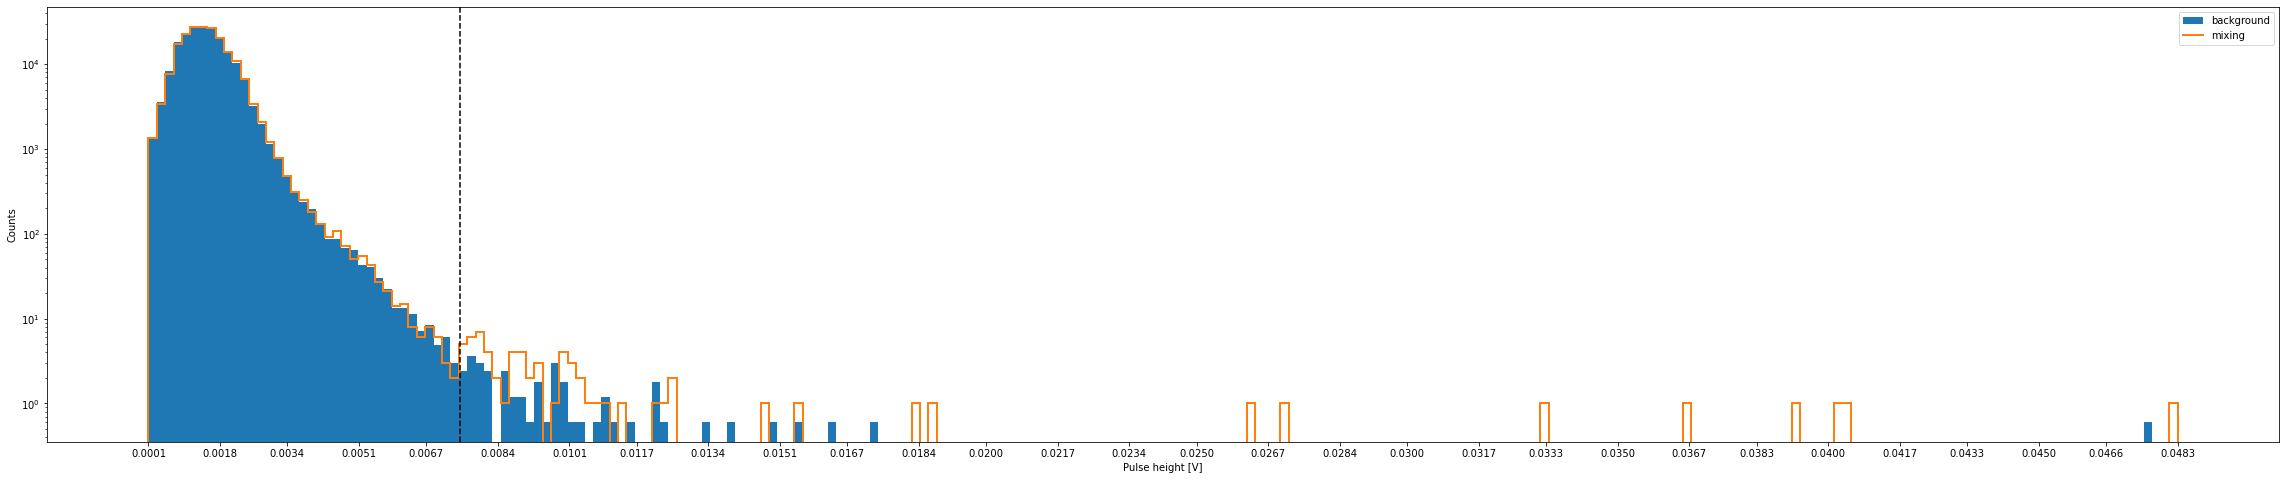

In [7]:
plt.figure(figsize = (40,8))
plt.xlabel('Pulse height [V]')
plt.ylabel('Counts')
plt.yscale('log')
plt.xticks([round(val,4) for val in np.linspace(ranges[0],ranges[-1],30)])
plt.stairs(histb, ranges, fill = True, label = 'background')
plt.stairs(histm, ranges, fill = False, linewidth = 2, label = 'mixing')
#for i in ranges: plt.axvline(i, linestyle = '--', c = 'k', alpha = 0.2)
plt.axvline(vthresh, c = 'k', linestyle = '--')
plt.legend(loc = 'best')

In [59]:
#mixing runs: 609, 616, 619, 622
#bkg runs: 611, 623

#when taking all files from the mixing runs:
#Number of mixing and background events: 504 , 723
#Number of events above 0.0075 V for mix: 69
#Number of events above 0.0075 V for bkg (without and with correction): 61 , 42.522821576763484
#Number of events in mix above 0.0075 corrected for bkg (total and per spill): 26.477178423236516 , 0.05253408417308832

#when taking out events with no positron waveform file:
#Number of mixing and background events: 450 , 723
#Number of events above 0.0075 V for mix: 63
#Number of events above 0.0075 V for bkg (without and with correction): 61 , 37.96680497925311
#Number of events in mix above 0.0075 corrected for bkg (total and per spill): 25.033195020746888 , 0.05562932226832642

#when taking out events with no positron waveform file and NE50_I < 7:
#Number of mixing and background events: 447 , 723
#Number of events above 0.0075 V for mix: 63
#Number of events above 0.0075 V for bkg (without and with correction): 61 , 37.713692946058096
#Number of events in mix above 0.0075 corrected for bkg (total and per spill): 25.286307053941904 , 0.05656891958376265

#when taking out events with no positron waveform file, NE50_I < 7 and no (low) positron peak:
#Number of mixing and background events: 424 , 723
#Number of events above 0.0075 V for mix: 58
#Number of events above 0.0075 V for bkg (without and with correction): 61 , 35.7731673582296
#Number of events in mix above 0.0075 corrected for bkg (total and per spill): 22.2268326417704 , 0.052421775098515096

#when taking out events with no positron waveform file, NE50_I < 7 and no (low) positron peak without run 609:
#Number of mixing and background events: 259 , 723
#Number of events above 0.0075 V for mix: 28
#Number of events above 0.0075 V for bkg (without and with correction): 61 , 21.85200553250346
#Number of events in mix above 0.0075 corrected for bkg (total and per spill): 6.147994467496542 , 0.023737430376434523

#when taking out events with no positron waveform file, NE50_I < 7 and no (low) positron peak with run 609 as only mixing run:
#Number of mixing and background events: 165 , 723
#Number of events above 0.0075 V for mix: 30
#Number of events above 0.0075 V for bkg (without and with correction): 61 , 13.921161825726141
#Number of events in mix above 0.0075 corrected for bkg (total and per spill): 16.07883817427386 , 0.09744750408650824

In [303]:
data = pd.concat([datafile[datafile.Date == '24_07_06'], 
                  datafile[datafile.Date == '24_07_07'], 
                  datafile[datafile.Date == '24_07_08']])

dfm = data[[True if val in [609,614,616,619,621,622] else False for val in data.run]]
#dfm = data[[True if val in [614] else False for val in data.run]]
dfm = dfm[dfm.run_mode == 1] #mixing
dfm = dfm[dfm.Positron_Waveform != 'None']
dfm = dfm[dfm.MCP5 != 'None']
dfm = dfm[dfm.NE50_I > 7]
#dfm = dfm[[True if len(sci.find_peaks(-Trc().open(val)[1][1][1380:1480], height = 0, distance = 20, prominence = 0.15)[0]) > 0 else False for val in dfm.Positron_Waveform]]
dfm = dfm[[True if len([1 for val in Trc().open(val)[1][3][1200:1800] if abs(val) > 0.01]) > 8 else False for val in dfm.Positron_Waveform]]
dfb = data[[True if val in [611,617,620,623] else False for val in data.run]]
dfb = dfb[dfb.run_mode == 2] #background
dfb = dfb[dfb.MCP5 != 'None']

corr = len(dfm)/len(dfb)

In [17]:
#lims_seq = [[7550, 8800],[7600, 8700],[7650, 8750],[7700, 8800],[7750, 8850],[7800, 8900],[7850, 8950],[7900, 9000],[7950, 9050],[8000, 9100]]
#lims_seq = [[7850, 8950],[7860, 8960],[7870, 8970],[7880, 8980],[7890, 8990],[7900, 9000],[7910, 9010],[7920, 9020],[7930, 9030],[7940, 9040],[7950, 9050]]
lims_start = [0, 12502]
steps = 1
step_size = 0
vthresh = 0.01

for k in range(steps):
    pm = [[], []]
    
    lims = [lims_start[0]+k*step_size, lims_start[1]+k*step_size]
    
    for i in tqdm(range(len(dfm))):
        curr_file = dfm.iloc[i]['Waveform_12bit']
        if curr_file != 'None':
            curr_data = Trc().open(curr_file)
            curr_p = sci.find_peaks(curr_data[1][2][lims[0]:lims[1]], height = 0.003, distance = 1, prominence = 0.000)
            pm[0] += [curr_p[0]]
            pm[1] += [curr_p[1]['peak_heights']]

    pb = [[], []]

    for i in tqdm(range(len(dfb))):
        curr_file = dfb.iloc[i]['Waveform_12bit']
        if curr_file != 'None':
            curr_data = Trc().open(curr_file)
            curr_p = sci.find_peaks(curr_data[1][2][lims[0]:lims[1]], height = 0.003, distance = 1, prominence = 0.000)
            pb[0] += [curr_p[0]]
            pb[1] += [curr_p[1]['peak_heights']]

    pmf = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfm.Waveform_12bit),pm[0])] for val in bal]
    pbf = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfb.Waveform_12bit),pb[0])] for val in bal]

    pml = [[val+lims[0] for bal in pm[0] for val in bal], [val for bal in pm[1] for val in bal]]
    pbl = [[val+lims[0] for bal in pb[0] for val in bal], [val for bal in pb[1] for val in bal]]

    eim = [val for val in list(dfm.NE50_I)]
    eib = [val for val in list(dfb.NE50_I)]

    eiml = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfm.NE50_I),pm[0])] for val in bal]
    eibl = [val for bal in [[val]*len(bal) for val,bal in zip(list(dfb.NE50_I),pb[0])] for val in bal]

    print('Limits are', lims[0], 'and', lims[1],':', len([1 for val in pml[1] if val >= vthresh]) - len([1 for val in pbl[1] if val >= vthresh])*corr, ',', (len([1 for val in pml[1] if val >= vthresh]) - len([1 for val in pbl[1] if val >= vthresh])*corr)/len(dfm))
    print(len([1 for val in pbl[1] if val >= vthresh]), len([1 for val in pbl[1] if val >= vthresh])*corr)

100%|██████████| 776/776 [00:04<00:00, 165.18it/s]


Limits are 0 and 12502 : 1003.6340206185569 , 2.1445171380738395
8719 5258.365979381443


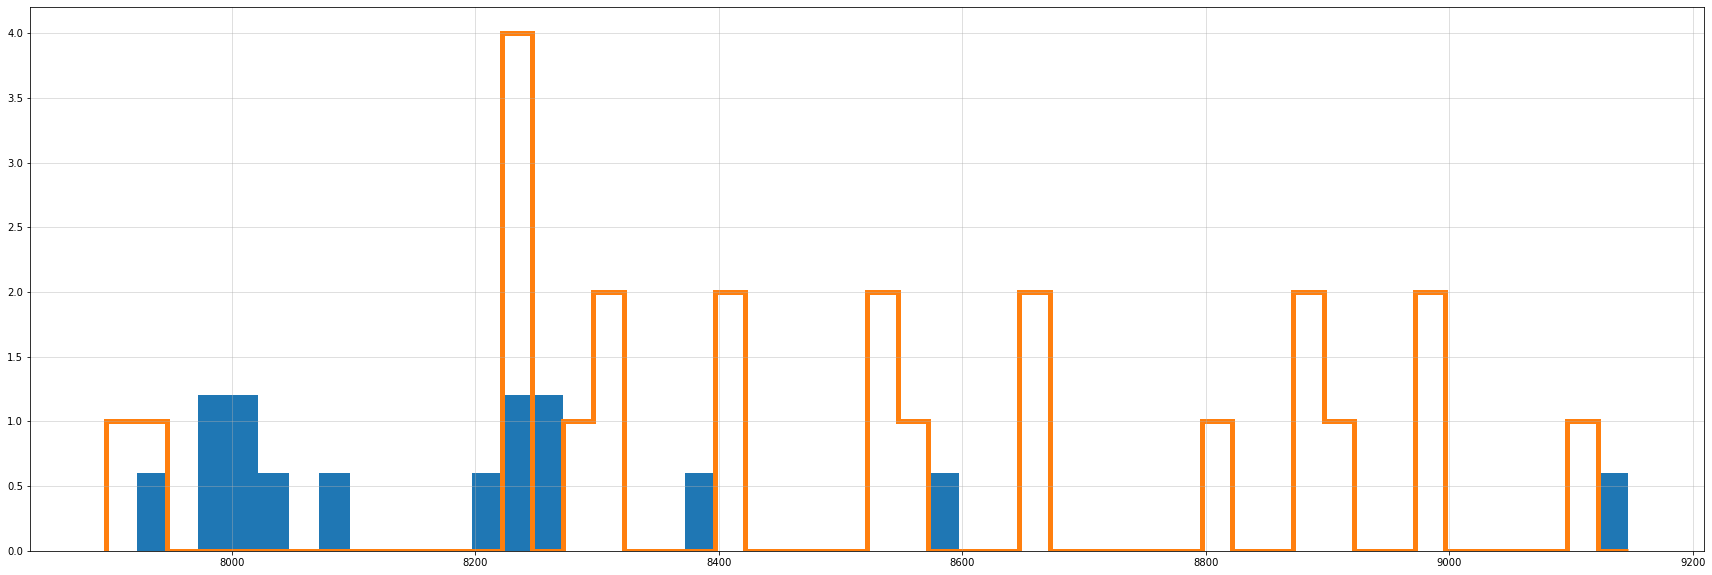

In [310]:
bins = 50
start = 7897
stop = 7897+1250
ranges = np.linspace(start, stop, bins+1)

pmth = np.histogram([val for val,bal in zip(pml[0],pml[1]) if bal>vthresh], range = [start, stop], bins = bins)[0]
pbth = np.histogram([val for val,bal in zip(pbl[0],pbl[1]) if bal>vthresh], range = [start, stop], bins = bins)[0]
pbth = corr*pbth

pmhh = np.histogram([val for val,bal in zip(pml[0],pml[1]) if bal>0.0075], range = [start, stop], bins = bins)[0]
pbhh = np.histogram([val for val,bal in zip(pbl[0],pbl[1]) if bal>0.0075], range = [start, stop], bins = bins)[0]
pbhh = corr*pbhh

plt.figure(figsize = (30,10))
plt.grid(alpha = 0.5)
#plt.yscale('log')

a = plt.stairs(pbth, edges = ranges, fill = True)
b = plt.stairs(pmth, edges = ranges, fill = False, linewidth = 5)

In [311]:
sum(pmth), sum(pbth), (sum(pmth)-sum(pbth))/len(dfm)

(23, 9.04639175257732, 0.029815402238082652)

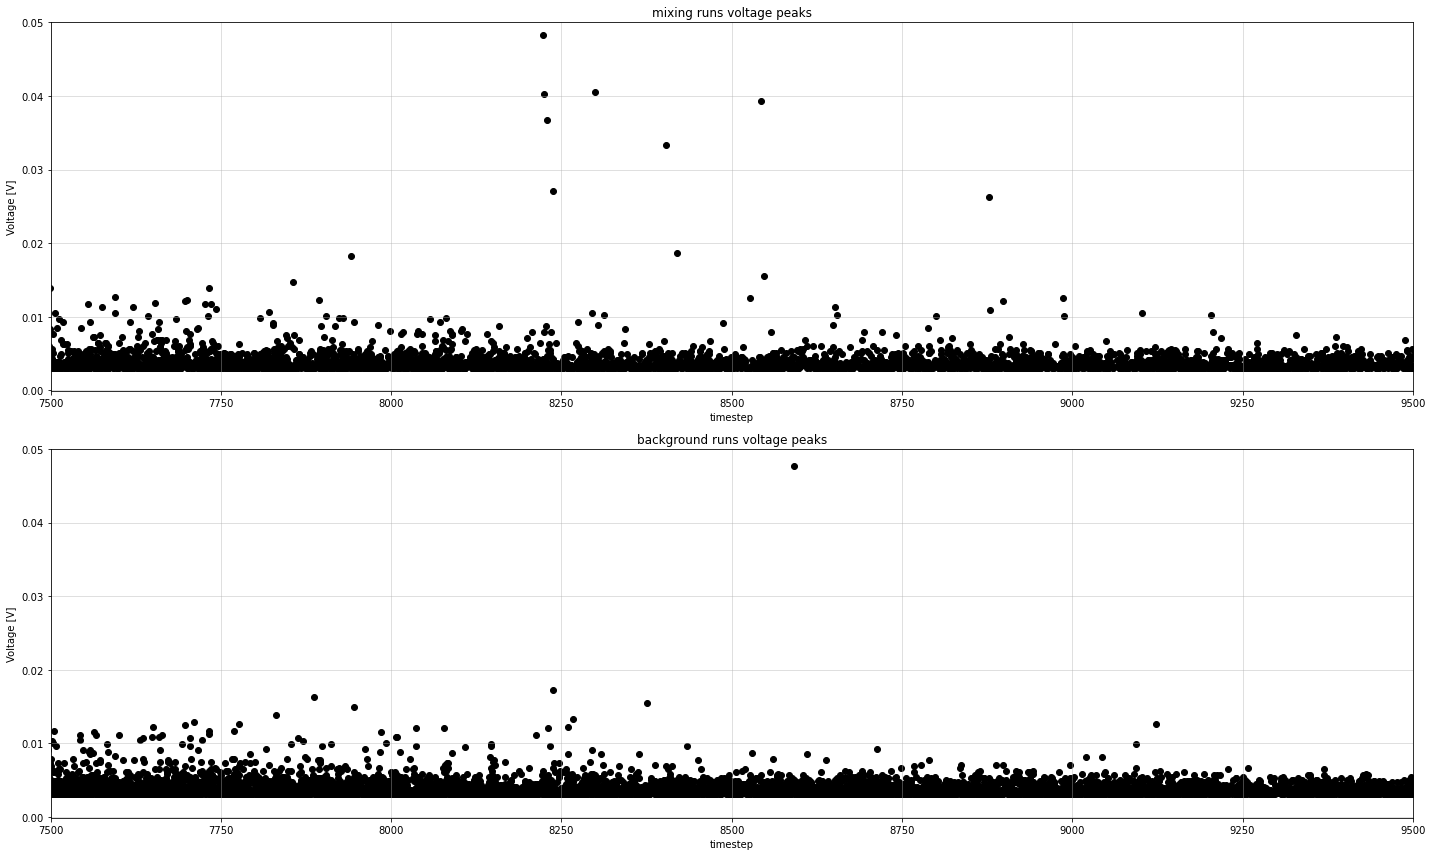

In [18]:
fig = plt.figure(layout = 'tight', figsize = (20,12))
gs = GridSpec(2, 1, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

ax1.scatter(pml[0], pml[1], c = 'k')
#ax1.scatter([val for val,bal in zip(pml[0],pml[1]) if bal > vthresh], [val for val in pml[1] if val > vthresh], c = 'r')

ax2.scatter(pbl[0], pbl[1], c = 'k')
#ax2.scatter([val for val,bal in zip(pbl[0],pbl[1]) if bal > vthresh], [val for val in pbl[1] if val > vthresh], c = 'r')

ax1.set_title('mixing runs voltage peaks')
ax2.set_title('background runs voltage peaks')

for i, ax in enumerate(fig.axes):
    ax.set_xlim([7500,9500])
    ax.set_ylim([-0.0001, 0.05])
    ax.grid(alpha = 0.5)
    ax.set_xlabel(xlabel = 'timestep')
    ax.set_ylabel(ylabel = 'Voltage [V]')

In [313]:
lims_start = 7400
tof_window = 1100
steps = 2001
step_size = 1
vthresh = 0.01
ls = []
evs = []
evsm = []
evsb = []

for i in tqdm(range(steps)):
    lims = [lims_start+i*step_size, lims_start+tof_window+i*step_size]
    temp_tm = [val for val,bal in zip(pml[0],pml[1]) if lims[0]<=val<lims[1] and vthresh < bal]
    temp_hm = [bal for val,bal in zip(pml[0],pml[1]) if lims[0]<=val<lims[1] and vthresh < bal]
    temp_tb = [val for val,bal in zip(pbl[0],pbl[1]) if lims[0]<=val<lims[1] and vthresh < bal]
    temp_hb = [bal for val,bal in zip(pbl[0],pbl[1]) if lims[0]<=val<lims[1] and vthresh < bal]
    evs += [(len(temp_tm)-len(temp_tb)*corr)/len(dfm)]
    ls += [lims[0]]
    evsm += [len(temp_tm)]
    evsb += [len(temp_tb)]

100%|██████████| 2001/2001 [02:05<00:00, 15.95it/s]


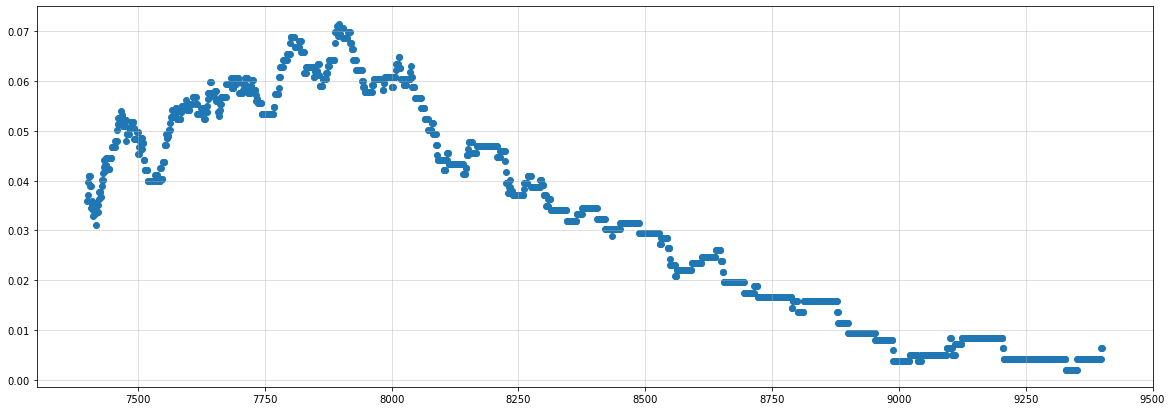

In [294]:
plt.figure(figsize = (20,7))
plt.grid(alpha = 0.5)

plt.scatter(ls, evs)

In [295]:
ls[np.argmax(evs)]

7897

In [ ]:
'''
Limits are 7700 and 8950 : 26.94882434301521 , 0.06355854797880946
Limits are 7720 and 8970 : 26.294605809128626 , 0.06201557973851091
Limits are 7740 and 8990 : 27.2268326417704 , 0.06421422792870378
Limits are 7760 and 9010 : 26.2268326417704 , 0.06185573736266604
Limits are 7780 and 9030 : 27.986168741355463 , 0.06600511495602704
Limits are 7800 and 9050 : 29.159059474412167 , 0.06877136668493436
Limits are 7820 and 9070 : 28.745504840940526 , 0.0677960019833503
Limits are 7840 and 9090 : 26.33195020746888 , 0.06210365614969075
Limits are 7860 and 9110 : 25.918395573997234 , 0.061128291448106685
Limits are 7880 and 9130 : 27.677731673582294 , 0.06527766904146767
Limits are 7900 and 9150 : 28.609958506224064 , 0.06747631723166053
Limits are 7920 and 9170 : 27.19640387275242 , 0.06414246196403872
Limits are 7940 and 9190 : 26.19640387275242 , 0.06178397139800099
Limits are 7960 and 9210 : 27.78284923928077 , 0.06552558782849238
Limits are 7980 and 9230 : 28.369294605809127 , 0.06690871369294606
Limits are 8000 and 9250 : 28.12863070539419 , 0.06634111015423158
Limits are 8020 and 9270 : 27.887966804979254 , 0.0657735066155171
Limits are 8040 and 9290 : 27.647302904564313 , 0.06520590307680263
Limits are 8060 and 9310 : 25.647302904564313 , 0.06048892194472715
Limits are 8080 and 9330 : 25.23374827109267 , 0.059513557243143084
Limits are 8100 and 9350 : 21.820193637621024 , 0.05146272084344581
'''

In [121]:
curr_data[0][0][0], curr_data[0][0][-1], curr_data[0][0][-1] - curr_data[0][0][0]

(0.00010300037349914474, 0.00011300117363266974, 1.0000800133525e-05)

In [120]:
curr_data[0][1][0], curr_data[0][1][-1], curr_data[0][1][-1] - curr_data[0][1][0]

(0.00010300016849593512, 0.00011300096862946012, 1.0000800133525e-05)

In [122]:
curr_data[0][2][0], curr_data[0][2][-1], curr_data[0][2][-1] - curr_data[0][2][0]

(0.00010300024520457191, 0.00011300104533809691, 1.0000800133525e-05)

In [169]:
curr_data[0][2][1250]-curr_data[0][2][0], curr_data[0][2][6600]-curr_data[0][2][0]

(1.000000013351432e-06, 5.280000070495561e-06)

In [159]:
9.994414789382552e-07/(curr_data[0][2][1]-curr_data[0][2][0]), len(curr_data[0][0])

(1249.3018319928506, 12502)

In [123]:
curr_data[0][3][0], curr_data[0][3][-1], curr_data[0][3][-1] - curr_data[0][3][0]

(0.00010300062821843692, 0.00011300142835196192, 1.0000800133525e-05)

In [316]:
tst = sorted(list(set(pbl[1])))
len([1 for val,bal in zip(tst[1:],tst[:-1]) if val-bal != 0.00019999999494757503])

12

In [319]:
(max(tst)-min(tst))/0.00019999999494757503

238.0

In [276]:
len([1 for val in pml[1] if val > 0.014]), len([1 for val in pbl[1] if val > 0.014])*corr, (len([1 for val in pml[1] if val > 0.014]) - len([1 for val in pbl[1] if val > 0.014])*corr)/len(dfm)

(11, 3.112033195020747, 0.01752881512217612)

In [264]:
len([1 for val in pml[1] if val > 0.013]), len([1 for val in pbl[1] if val > 0.013])*corr, (len([1 for val in pml[1] if val > 0.013]) - len([1 for val in pbl[1] if val > 0.013])*corr)/len(dfm)

(2, 0.5228215767634855, 0.02735515598586138)

In [278]:
corr

0.6224066390041494

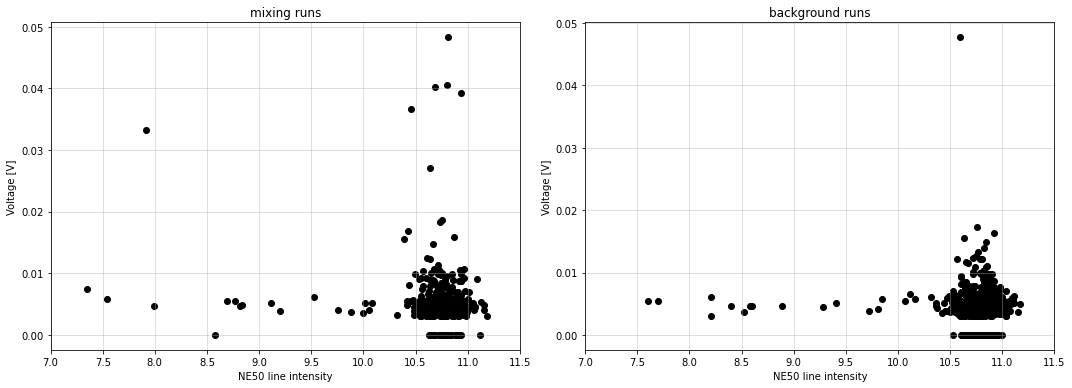

In [122]:
fig = plt.figure(layout = 'tight', figsize = (15,5.5))
gs = GridSpec(1, 2, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.scatter(eim, [max(val) if len(val)>0 else 0 for val in pm[1]], c = 'k')
ax2.scatter(eib, [max(val) if len(val)>0 else 0 for val in pb[1]], c = 'k')

ax1.set_title('mixing runs')
ax2.set_title('background runs')

for i, ax in enumerate(fig.axes):
    ax.grid(alpha = 0.5)
    ax.set_xlim(7, 11.5)
    ax.set_xlabel(xlabel = 'NE50 line intensity')
    ax.set_ylabel(ylabel = 'Voltage [V]')

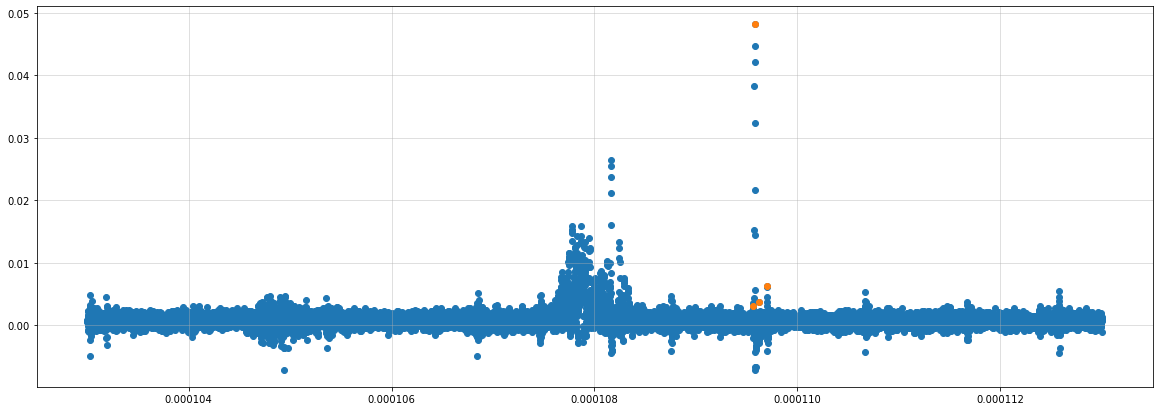

In [96]:
data = Trc().open(pmf[np.argmax(pml[1])])
pcurr = sci.find_peaks(data[1][2][lims[0]:lims[1]], 0.003, distance = 20, prominence = 0.004)

plt.figure(figsize = (20,7))
plt.grid(alpha = 0.5)
plt.scatter(data[0][2], data[1][2])
plt.scatter([data[0][2][val+lims[0]] for val in pcurr[0]], pcurr[1]['peak_heights'])

In [318]:
fbadposi = ['/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297524.521.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297635.634.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297750.820.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297869.714.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297981.792.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298096.526.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298215.801.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298326.899.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298439.713.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298556.586.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298685.702.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298799.686.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298916.591.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299045.690.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299159.689.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299276.565.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299405.694.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299519.696.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299765.683.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299879.683.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299996.558.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720301319.638.trc']
fbadwf = list(datafile[[True if val in fbadposi else False for val in datafile.Positron_Waveform]].Waveform_12bit)

In [321]:
lims = [7750, 8850]

for i in range(len(fbadwf)):
    temp_p = sci.find_peaks(Trc().open(fbadwf[i])[1][2][lims[0]:lims[1]], 0.003, distance = 20, prominence = 0.004)
    if len(temp_p[0]) > 0 and max(temp_p[1]['peak_heights']) > 0.0075:
        print(i, temp_p[0], temp_p[1]['peak_heights'], '\n')

0 [402 723 917 969] [0.00310002 0.01050002 0.00510002 0.00330002] 

12 [221 645] [0.00350002 0.00930002] 

13 [  45  518  569  626 1018] [0.00530002 0.00330002 0.00530002 0.00330002 0.00990002] 

15 [312 765 853] [0.00950002 0.00370002 0.00550002] 



In [347]:
fbadwf[0] in pmf

True

(0.00010920051921960409, 0.00011008051923135335)

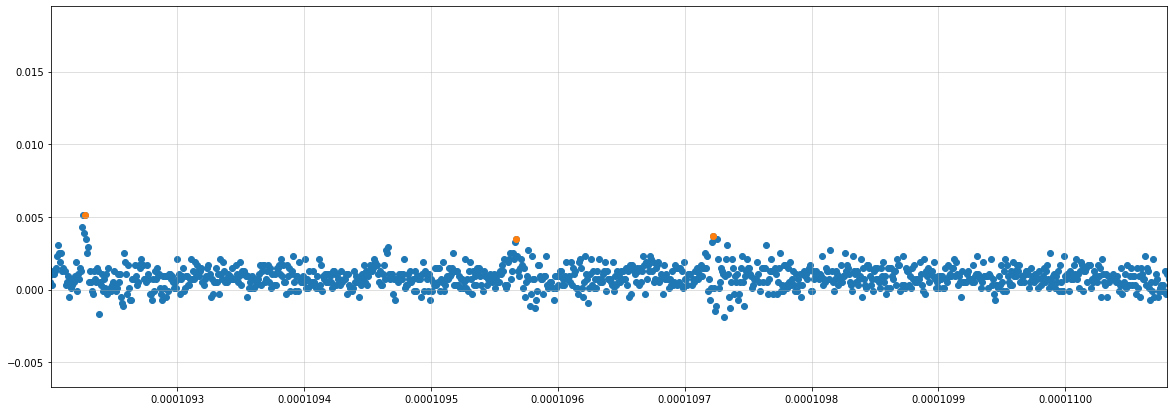

In [343]:
data = Trc().open(fbadwf[16])
pcurr = sci.find_peaks(data[1][2][lims[0]:lims[1]], 0.003, distance = 20, prominence = 0.004)

plt.figure(figsize = (20,7))
plt.grid(alpha = 0.5)
plt.scatter(data[0][2], data[1][2])
plt.scatter([data[0][2][val+lims[0]] for val in pcurr[0]], pcurr[1]['peak_heights'])
plt.xlim(data[0][2][lims[0]], data[0][2][lims[1]])

(0.00010920025883668804, 0.0001100802588484373)

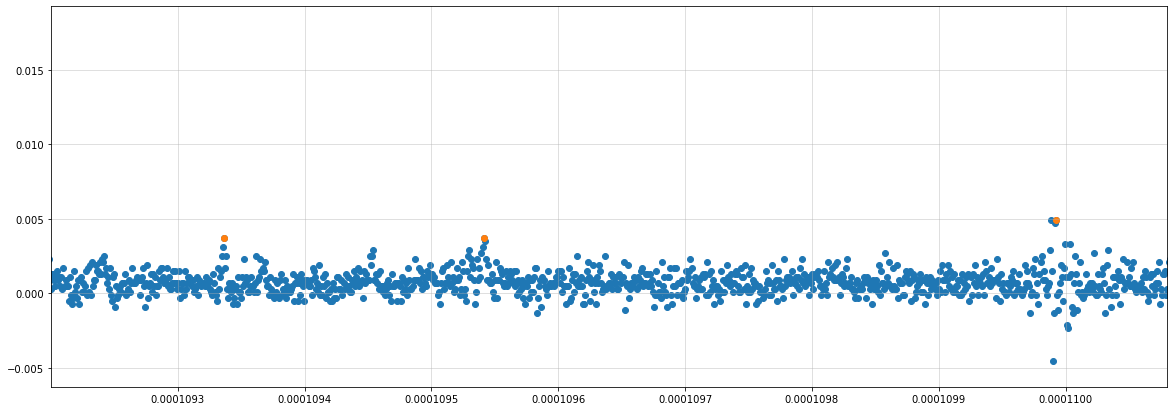

In [342]:
data = Trc().open(list(dfm.Waveform_12bit)[3])
pcurr = sci.find_peaks(data[1][2][lims[0]:lims[1]], 0.003, distance = 20, prominence = 0.004)

plt.figure(figsize = (20,7))
plt.grid(alpha = 0.5)
plt.scatter(data[0][2], data[1][2])
plt.scatter([data[0][2][val+lims[0]] for val in pcurr[0]], pcurr[1]['peak_heights'])
plt.xlim(data[0][2][lims[0]], data[0][2][lims[1]])

In [147]:
dfm

,Date,Time,Datetime,run,run_mode,event_number,DAQ,pbar_trap,positron,MCP1,MCP2,MCP3,MCP3.5,MCP4,MCP5,MCP7,Waveform_12bit,CMOS_Tracker,DRS4,Positron_Waveform,SD,LyA,SD_LyA,Cy_Des,NE00_I,NE50_I,NE00_Bm1,NE00_Bm2,NE00_Bm3,NE50_Bm1,NE50_Bm2,Int,Valve_in,MCP_in,MW_power,H-sou_pressure,cube_pressure,RC_pressure,MW_pressure,SwY_pressure,LyA_pressure,Main_delay,PCOs_delay,LyA_delay,Laser_delay,FC_current,MCP4_current,MCP5_current,St_dec_up,St_dec_dw,St_dec_ri,St_dec_le,St_Cub_up,St_Cub_dw,St_Cub_ri,St_Cub_le,St_RC1_up,St_RC1_dw,St_RC1_ri,St_RC1_le,St_RC2_up,St_RC2_dw,St_RC2_ri,St_RC2_le,St_RC3_up,St_RC3_dw,St_RC3_ri,St_RC3_le,St_Al1_up,St_Al1_dw,St_Al1_ri,St_Al1_le,St_Al2_up,St_Al2_dw,St_Al2_ri,St_Al2_le,QT_RC1_+,QT_RC1_-,QT_RC2_+,QT_RC2_-,QT_RC3_+,QT_RC3_-,SwY_1_+,SwY_1_-,SwY_3_+,SwY_3_-,EL_pT_in,EL_pT_1,EL_pT_2,EL_pT_3,EL_pT_4,EL_RC_in,EL_SwY_+,EL_Al1_+,EL_Al2_+,EL_Al3_+,Ly_MCP_1,Ly_MCP_2,Ly_MCP_3,Ly_MCP_4,Qnch_+,Qnch_-,TgDefl_+,H-Defl_+,H-Cor1_-,H-Cor1-,1_phos_+,1_mcp_+,2_phos_+,2_mcp_+,3_phos_+,3_mcp_+,3.5_grid_-,3.5_phos_+,3.5_mcp_+,4_phos_+,4_mcp_+,5_phos_+,5_mcp_+,6_phos_+,6_mcp_+,7_phos_+,7_mcp_+,Sci_1_-,Sci_2_-,H_offs,target_pos,front_bias,mw_amp_curr,hfs_temp,hfs_freq,hfs_pow,sc_temp,sc_freq,sc_pow,empty_1,empty_2,empty_3,empty_4,empty_5,empty_6,empty_7,empty_8
11827,24_07_07,1.720350e+09,2024-07-07 12:59:00.454000,616.0,1.0,1,0.0,0,0,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/PCO-...,None,/eos/experiment/gbar/pgunpc/data/24_07_07/WF12...,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/24_0...,None,None,None,Pbar_2024_NewOptics,10.453,10.564,0.0,0.0,0.0,0.0,0.0,47.332,335580103.0,0.0,9.128047e-08,1.200000e-08,9.380000e-09,2.717000e-09,2.990000e-09,5.530000e-09,1.010000e-09,0.000902,0.001006,0.00101,0.000999,2.426076e-07,1.970142e-07,0.000083,49.95938,-49.98754,9.961709,-9.973126,14.93922,-14.99201,-14.97687,14.96442,-34.98926,34.95744,9.962339,-9.957728,-37.79517,37.93468,-13.79205,13.96072,-59.78304,59.99503,-24.81906,25.04024,0.020379,0.029746,0.026256,0.023472,0.027383,0.015214,0.015146,0.018204,-73.03706,72.71491,-101.0818,100.7147,-133.0455,132.6908,1099.838,-1099.965,599.8463,-599.9383,-1549.995,-3299.987,-2199.956,-1499.966,0.517866,-2049.999,-0.075553,-0.231540,-0.158462,-0.167014,-0.777184,-0.719831,-0.73301,-0.767342,-0.004203,-0.147833,699.8654,-0.044975,-0.763885,-0.763802,0.10218,-0.024289,-0.020686,-0.007241,-0.016155,-0.022725,0.061755,-0.009781,-0.033213,-0.115994,-0.014161,4000.002,2199.999,-0.135685,-0.145297,-0.001161,-0.050394,-939.9965,-939.9970,0.000103,111.0,0.0,0.0,49.7,1.162000e+09,-3.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11828,24_07_07,1.720350e+09,2024-07-07 13:00:56.856000,616.0,1.0,2,0.0,0,0,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/PCO-...,None,/eos/experiment/gbar/pgunpc/data/24_07_07/WF12...,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/24_0...,None,None,None,Pbar_2024_NewOptics,10.373,10.577,0.0,0.0,0.0,0.0,0.0,47.364,335580103.0,0.0,-3.006395e-07,1.200000e-08,9.410000e-09,2.727000e-09,2.980000e-09,5.550000e-09,1.010000e-09,0.000902,0.001006,0.00101,0.000999,2.462450e-07,1.947849e-07,0.000083,49.95621,-49.98991,9.958032,-9.975241,14.93678,-14.99460,-14.97951,14.96036,-34.99249,34.95444,9.958865,-9.959918,-37.79295,37.93985,-13.78873,13.96816,-59.77958,59.99869,-24.81578,25.04338,0.024859,0.036220,0.029243,0.027704,0.034355,0.017951,0.019377,0.020444,-73.03629,72.71703,-101.0805,100.7193,-133.0461,132.6918,1099.841,-1099.965,599.8479,-599.9382,-1550.002,-3299.987,-2199.979,-1499.994,0.404131,-2050.001,-0.075553,-0.234004,-0.158462,-0.167014,-0.777184,-0.719831,-0.73301,-0.767342,-0.004203,-0.147833,699.8679,-0.040028,-0.763885,-0.763802,0.10218,-0.024289,-0.019202,-0.008724,-0.020597,-0.016793,0.076587,-0.008299,-0.039132,-0.122914,-0.014161,4000.000,2200.000,-0.141625,-0.145297,0.003778,-0.045454,-939.9995,-940.0043,0.000103,111.0,0.0,0.0,49.7,1.162000e+09,-3.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11829,24_07_07,1

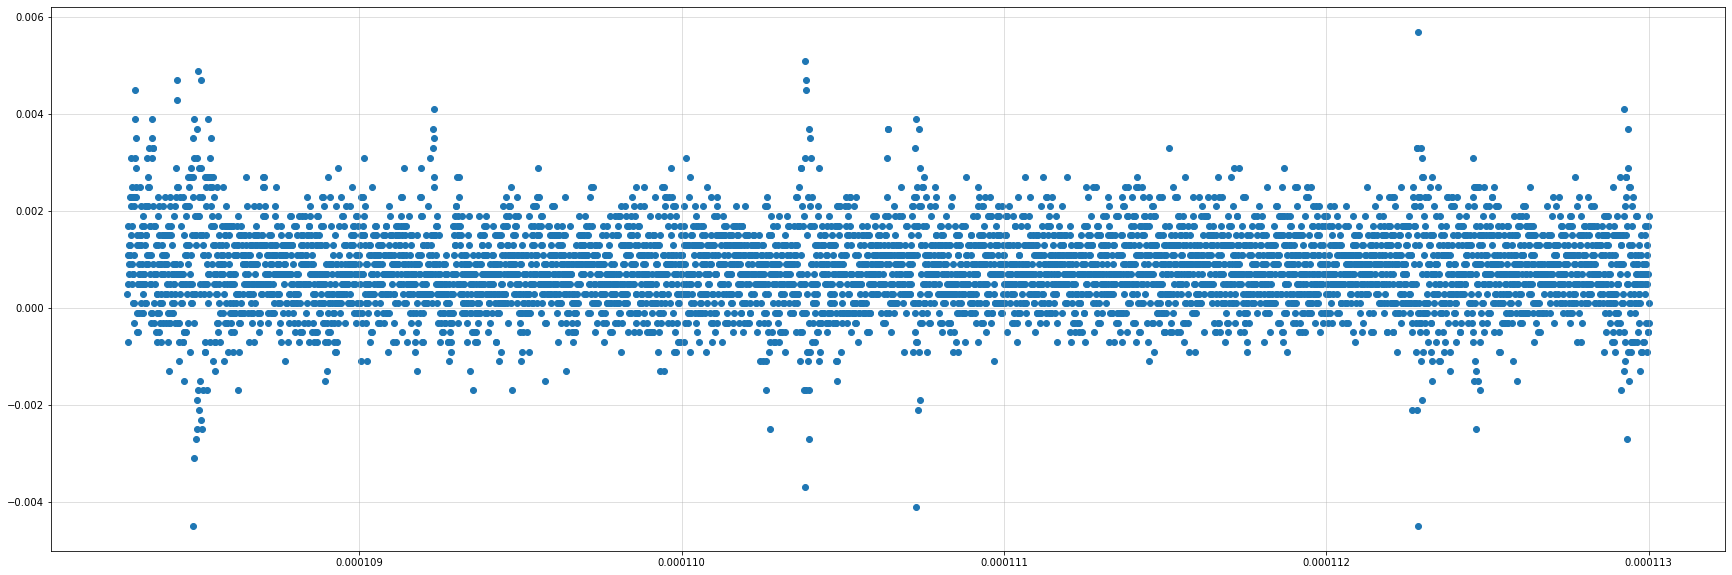

In [154]:
tst = dfm.iloc[200].Waveform_12bit
tstd = Trc().open(tst)

plt.figure(figsize = (30,10))
plt.grid(alpha = 0.5)
plt.scatter(tstd[0][2][6600:], tstd[1][2][6600:])